# Import Libraries and Utils Function

In [1]:
!pip install casadi
import casadi as cs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 17.8 MB/s eta 0:00:00:00:0100:01


# Stiffness Based Centroidal Dynamics

In [2]:
class StiffnessBasedCentroidalDynamics:

    def __init__(self, n_e, n_div, surfaces, N, sigma, opti):
        
        self.n_e = n_e
        self.n_div = n_div
        self.surfaces = surfaces
        self.N = N
        self.sigma = sigma
        self.opti = opti
        
        self.duration = int(N/25)
        
        self.epsilon = 1e-6
        self.g = [0,0,9.81]
        self.mu = 0.3
        self.mu_z = 0.6
        self.tau_min = 0.1
        self.tau_max = 100
        self.m = 10
        self.LAMBDA_max = 1000
        self.feet_length = 0.1
        
        # for cost
        self.SIGMA_L_k = opti.parameter(n_e, N)  # (n_e, N)  
        self.ETA_NORMAL_L = opti.parameter(3, len(surfaces))  # (3, surfaces)  # (3,3)
        self.O_L = opti.parameter(3, len(surfaces))   # (3, surfaces)          # (3,3)
        self.w_compl = opti.parameter(1)  # Complementarity weight
        self.W_x_k = opti.parameter(28,28)  # State weight matrix
        self.W_u_k = opti.parameter(27,27)  # Input weight matrix
        self.x_0 = opti.parameter(28)

        weights_x = [1.0] * 28  # Higher weight for the first 18 components
        W_x_k = cs.diag(weights_x)  # Create a diagonal matrix from the weights
        weights_u = [1] + [0.0001] * 12 + [1]*2 +[0.0001] * 12# Higher weight for the first 18 components
        W_u_k = cs.diag(weights_u)  # Create a diagonal matrix from the weights
        
        # Set the weight matrix in the optimizer
        opti.set_value(self.W_x_k, W_x_k)
        opti.set_value(self.W_u_k, W_u_k)
        opti.set_value(self.ETA_NORMAL_L, cs.DM([0, 0, 1]))
        opti.set_value(self.O_L, cs.DM([0, 0, 0]))
        opti.set_value(self.SIGMA_L_k, sigma)
        opti.set_value(self.w_compl, 1000)
        
    def init_state(self, X):
        n_e = self.n_e
        
        X_init = np.zeros(X.shape[0])
        start_pos = np.array([0.0, 0.0, 0.5])      # Initial CoM position
        start_orient = np.array([1,0,0,0])
        start_vel = np.zeros(3)
        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])  # Initial feet positions (distance 0.5 from CoM)
        start_feet_orient = np.array([[1, 0, 0, 0], [1, 0, 0, 0]])  # Neutral orientations
        
        X_init[0:3] = start_pos
        X_init[3:7] = start_orient
        X_init[7:10] = start_vel
        X_init[14:14+3*n_e] = start_feet_pos.flatten()
        X_init[14 + 3*n_e:14 + 3*n_e + 4*n_e] = start_feet_orient.flatten()
        return X_init
    
    # defining f_l (+func) and eta_l (+func)
    def define_contact_wrench(self, p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k):
        # Taking f_l and eta_l from eq.3.1 and eq.3.2
        # Eq. 3.1 : Translational component of the contact wrench
        P_k = cs.repmat(p_k, 1, self.n_e) # (3, n_e)
        F_L = self.m * cs.mtimes((P_k - (P_L_k + R_L_k)), cs.diag(LAMBDA_L_k**2))  # (3, n_e)
        
        # Eq. 3.2 : Angular component of the contact wrench
        ETA_L = self.m * cs.mtimes(ETA_HAT_L_k, cs.diag(LAMBDA_L_k**2))   # (3, n_e)
        return F_L, ETA_L

    def quaternion(self, w, tau_k_prime):
        w_norm = cs.norm_2(w)
        theta = 0.5 * tau_k_prime * w_norm  # Half-angle for rotation
        q_v = cs.if_else(w_norm > 1e-6, cs.sin(theta) * w / w_norm, cs.DM.zeros(3))
        q_w = cs.cos(theta)
        return cs.vertcat(q_w, q_v)  # Quaternion [w, x, y, z]
    
    def quaternion_product(self,q1, q2):
        w1, x1, y1, z1 = q1[0], q1[1], q1[2], q1[3]
        w2, x2, y2, z2 = q2[0], q2[1], q2[2], q2[3]
    
        w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
        x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
        y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
        z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    
        return cs.vertcat(w, x, y, z)
        
    def update_q_l_k(self, W_L_k, tau_k, q_k):
        q_quaternions = []
        _, col = W_L_k.size()    # it should be n_e
    
        for i in range(col):
            q_temp = self.quaternion(W_L_k[:,i], tau_k)  # (4,1)
            q_prod = self.quaternion_product(q_temp, q_k)   # (4,1)
            q_quaternions.append(q_prod)
    
        q_k_plus_one = cs.horzcat(*q_quaternions)
        
        return q_k_plus_one
    
    def get_x_comp(self, x_k):
        p_k = x_k[0:3]  # (3,1), corresponds to p_k (position)
        q_k = x_k[3:7]  # (4,1), corresponds to q_k (orientation as quaternion)
        v_k = x_k[7:10]  # (3,1), corresponds to v_k (velocity)
        L_k = x_k[10:13]  # (3,1), corresponds to L_k (angular momentum)
        t_k = x_k[13:14]  # (1,1), current instant of time (instant of time inside a phase)
        P_L_k_flat = x_k[14:14+3*self.n_e]  # (3*n_e, 1) positions of end-effectors
        Q_L_k_flat = x_k[14+3*self.n_e:14+3*self.n_e+4*self.n_e]  # (4*n_e, 1) orientations (quaternions) of end-effectors
        P_L_k = cs.reshape(P_L_k_flat, 3, self.n_e)
        Q_L_k = cs.reshape(Q_L_k_flat, 4, self.n_e)
        return p_k, q_k, v_k, L_k, t_k, P_L_k, Q_L_k

    def get_u_comp(self, u_k):
        tau_k = u_k[0]
        V_L_k_flat = u_k[1:1+3*self.n_e]
        W_L_k_flat = u_k[1+3*self.n_e:1+6*self.n_e]
        LAMBDA_L_k = u_k[1+6*self.n_e:1+7*self.n_e]
        R_L_k_flat = u_k[1+7*self.n_e:1+10*self.n_e]
        ETA_HAT_L_k_flat = u_k[1+10*self.n_e:1+13*self.n_e]
        V_L_k = cs.reshape(V_L_k_flat, 3, self.n_e)
        W_L_k = cs.reshape(W_L_k_flat, 3, self.n_e)
        R_L_k = cs.reshape(R_L_k_flat, 3, self.n_e)
        ETA_HAT_L_k = cs.reshape(ETA_HAT_L_k_flat, 3, self.n_e)
        return tau_k, V_L_k, W_L_k, LAMBDA_L_k, R_L_k, ETA_HAT_L_k
    
    # returns x_k+1
    def update_dynamics(self, x_k, u_k):
        # extracting components from x_k
        p_k, q_k, v_k, L_k, t_k, P_L_k, Q_L_k = self.get_x_comp(x_k)
        
        # extracting components from u_k
        tau_k, V_L_k, W_L_k, LAMBDA_L_k, R_L_k, ETA_HAT_L_k = self.get_u_comp(u_k)
        
        # Eq. 5.1 : lambda_bar
        lambda_bar = cs.sqrt(cs.sumsqr(LAMBDA_L_k) + self.epsilon**2)  # (1,1)
        
        # Eq. 5.2 : p_bar
        p_bar = ((P_L_k @ (LAMBDA_L_k**2)) + self.g) / lambda_bar**2  # (3,1)
        
        # Eq. 5.3 : r_bar
        r_bar = (R_L_k @ (LAMBDA_L_k**2)) / lambda_bar**2  # (3,1)
        
        # Eq. 5.4 : eta_bar
        eta_bar = (
            lambda_bar**2 * cs.cross(p_bar, r_bar) +
            (ETA_HAT_L_k - cs.cross(P_L_k, R_L_k, 1)) @ (LAMBDA_L_k**2)
        )  # (3,1)

        C_k = cs.cosh(lambda_bar * tau_k)    # C_k(t-t_k), scalar
        S_k = cs.sinh(lambda_bar * tau_k)    # S_k(t-t_k), scalar

        p_k_plus_one = (
            p_bar + r_bar +
            C_k * (p_k - (p_bar + r_bar)) +
            (S_k / lambda_bar) * v_k
        )
        
        v_k_plus_one = (
            lambda_bar * S_k * (p_k - (p_bar + r_bar)) +
            C_k * v_k
        )

        L_k_plus_one = (
            L_k +
            self.m * (
                cs.cross((v_k_plus_one - v_k), r_bar) +
                tau_k * eta_bar
            )
        )

        t_k_plus_one = t_k + tau_k

        # update q_k
        w, x, y, z = q_k[0], q_k[1], q_k[2], q_k[3]
        
        R_t = cs.vertcat(
            cs.horzcat(1 - 2 * (y**2 + z**2), 2 * (x * y - w * z), 2 * (x * z + w * y)),
            cs.horzcat(2 * (x * y + w * z), 1 - 2 * (x**2 + z**2), 2 * (y * z - w * x)),
            cs.horzcat(2 * (x * z - w * y), 2 * (y * z + w * x), 1 - 2 * (x**2 + y**2))
        )
        
        tau_k_prime = tau_k / self.n_div
        q_new = q_k
    
        for i in range(self.n_div):
            t_i_prime = t_k + tau_k_prime * i  
            C_prime = cs.cosh(lambda_bar * (t_i_prime - t_k))    # C_k(t-t_k), scalar
            S_prime = cs.sinh(lambda_bar * (t_i_prime - t_k))
            v_t_prime = ( lambda_bar * S_prime * (p_k - (p_bar + r_bar)) + C_prime * v_k )
            L_t_prime = (L_k + self.m * (cs.cross((v_t_prime - v_k), r_bar) + (t_i_prime - t_k) * eta_bar) )
        
            # Reference linear displacement
            L_ref_t = cs.DM.eye(3)  # Assuming L_ref = 0
        
            # Inverse of reference inertia matrix
            I_ref_inv = cs.inv(cs.diag(cs.DM([2, 3, 4])))  # Constant matrix
        
            # Compute w_t
            w_t = R_t @ I_ref_inv @ (R_t.T @ L_t_prime - L_ref_t)

            t_i_prime = t_k + tau_k_prime * i
            omega =  w_t * tau_k_prime
            q_temp = self.quaternion(w, tau_k_prime)
            q_new = self.quaternion_product(q_temp, q_new)

        q_k_plus_one = q_new
        
        p_l_k_plus_one = P_L_k + V_L_k * tau_k
        p_l_k_plus_one_flat = cs.reshape(p_l_k_plus_one, (p_l_k_plus_one.shape[0]*p_l_k_plus_one.shape[1], 1))
        
        q_l_k_plus_one = self.update_q_l_k(W_L_k, tau_k, q_k)
        q_l_k_plus_one_flat = cs.reshape(q_l_k_plus_one, (q_l_k_plus_one.shape[0]*q_l_k_plus_one.shape[1], 1))
        
        x_k_plus_one = cs.vertcat(
                p_k_plus_one,              # Position update
                q_k_plus_one,              # Quaternion update
                v_k_plus_one,              # Velocity update
                L_k_plus_one,              # Angular momentum update
                t_k_plus_one,              # Time update
                p_l_k_plus_one_flat,       # End position update
                q_l_k_plus_one_flat        # Flattened orientation matrix update
            )
        
        return x_k_plus_one

    def constraint_lambda(self, p_k_ref, P_L_k_ref, LAMBDA_L_k_ref, g):
        diff = cs.mtimes(cs.repmat(p_k_ref, 1, self.n_e) - P_L_k_ref, LAMBDA_L_k_ref**2) - g
        lambda_obj = 0.5 * cs.mtimes(diff.T, diff)
        self.opti.minimize(lambda_obj)

        self.opti.solver("ipopt")
        solution = self.opti.solve()        
        LAMBDA_L_sol = solution.value(LAMBDA_L_k_ref)
        
        return LAMBDA_L_sol

    def constraint_box(self, p_k, P_L_k):

        self.opti.subject_to(cs.sumsqr(P_L_k[0:3] - p_k) <= 1) # euclidian distance have square root, but it cause optimization problems
        self.opti.subject_to(cs.sumsqr(P_L_k[3:6] - p_k) <= 1) # but we have an equivalent formulation by setting <= maxdistance^2 (1**2 = 1vin this case)
        
        return 
        
    def constraint_vector(self, q_k, p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k, tau_k):
        F_L, ETA_L = self.define_contact_wrench(p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k)
        mu = self.mu
        mu_z = self.mu_z 
        feet_length = self.feet_length
        g_vector = []
        
        g_vector.append(tau_k - self.tau_min)
        g_vector.append(self.tau_max - tau_k)
        g_vector.append(LAMBDA_L_k)
        g_vector.append(self.LAMBDA_max - LAMBDA_L_k)
        
        for i in range(self.n_e):
                        
            f_l_x, f_l_y, f_l_z = F_L[0, i], F_L[1, i], F_L[2, i]
            eta_l_x, eta_l_y, eta_l_z = ETA_L[0, i], ETA_L[1, i], ETA_L[2, i]
            
            # Eq. 20: Non-slip condition
            g_vector.append(mu * f_l_z - cs.sqrt(f_l_x**2 + f_l_y**2))

            """ 
            # Eq. 21a 
            g_vector.append(eta_l_x / f_l_z + feet_length)
            g_vector.append(-eta_l_x / f_l_z - feet_length)

            # Eq. 21b 
            g_vector.append(eta_l_y / f_l_z - feet_length)
            g_vector.append(-eta_l_y / f_l_z + feet_length)

             
            # Eq. 21c 
            g_vector.append(eta_l_z / f_l_z + mu_z)
            g_vector.append(-eta_l_z / f_l_z + mu_z)
            """ 
            
        # Convert g_vector to a CasADi MX vector
        g_constraint = cs.vertcat(*g_vector)  # (14, 1) = (n_g, 1), where n_g is the total number of inequality constraints
        return g_constraint

    def limit_cost(self, q_k, p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k, tau_k):
        # Log-Barrier Function
        m = self.m
        
        epsilon = self.epsilon
        g_constraint = self.constraint_vector(q_k, p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k, tau_k)
        
        L_limit = -cs.sum1(cs.log(cs.fmax(epsilon, g_constraint)))  # Log-barrier term
        
        return L_limit

    def contact_dependent_cost(self, P_L_k, V_L_k, W_L_k, LAMBDA_L_k, SIGMA_L_k):
        # Initialize the cost
        L_compl_k = 0
        
        for l in range(self.n_e):  # Loop over ends
            # First term: Distance to contact face
            contact_cost = 0
            for i in self.surfaces:    # SIGMA_L_k (n_e, N)
                delta_contact = cs.if_else(SIGMA_L_k[l] == i, 1, 0)
                contact_cost += delta_contact * (cs.dot(self.ETA_NORMAL_L[:, i], P_L_k[:, l] - self.O_L[:, i]) ** 2)
        
            # Second term: End velocity cost
            delta_velocity = cs.if_else(SIGMA_L_k[l] != -1, 1, 0)  # Not off-contact
            velocity_cost = delta_velocity * (cs.norm_2(V_L_k[:, l]) ** 2 + cs.norm_2(W_L_k[:, l]) ** 2)
        
            # Third term: Stiffness cost
            delta_off_contact = cs.if_else(SIGMA_L_k[l] == -1, 1, 0)  # Off-contact
            stiffness_cost = delta_off_contact * (LAMBDA_L_k[l] ** 2)
        
            # Combine terms
            L_compl_k += contact_cost + stiffness_cost + velocity_cost
        
        # Scale by w_compl^2
        L_compl_k *= self.w_compl ** 2
        return L_compl_k
    
    # defining task-related cost function
    def task_related_cost(self, x_k, u_k, x_k_ref, u_k_ref):
        W_x_k = self.W_x_k  # State weight matrix
        W_u_k = self.W_u_k  # Input weight matrix
        
        # Eq. 16 : Task-related cost function
        L_task_k = 0.5 * cs.mtimes([(x_k - x_k_ref).T, W_x_k, (x_k- x_k_ref)]) + \
                   0.5 * cs.mtimes([(u_k - u_k_ref).T, W_u_k, (u_k - u_k_ref)])
        
        return L_task_k
        

    def impose_constraints(self, X, U, X_ref, U_ref):
        
        self.opti.subject_to()
        N_intervals = U.shape[1]
        cost = 0
        SIGMA_L = self.SIGMA_L_k
        
        for k in range(N_intervals): # number of phases 
            x_k = X[:, k]
            u_k = U[:, k]
            x_k_ref = X_ref[:, k]
            u_k_ref = U_ref[:, k]

            p_k, q_k, v_k, L_k, t_k, P_L_k, Q_L_k = self.get_x_comp(x_k)
            
            tau_k, V_L_k, W_L_k, LAMBDA_L_k, R_L_k, ETA_HAT_L_k = self.get_u_comp(u_k)
            
            p_k_ref, q_k_ref, v_k_ref, L_k_ref, t_k_ref, P_L_k_ref, Q_L_k_ref = self.get_x_comp(x_k_ref)
        
            tau_k_ref, V_L_k_ref, W_L_k_ref, LAMBDA_L_k_ref, R_L_k_ref, ETA_HAT_L_k_ref = self.get_u_comp(u_k_ref) 

            SIGMA_L_k = SIGMA_L[:, k]   
            task_cost_k = self.task_related_cost(x_k, u_k, x_k_ref, u_k_ref)
            limit_cost_k = self.limit_cost(q_k, p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k, tau_k)
            contact_dependent_cost_k = self.contact_dependent_cost(P_L_k, V_L_k, W_L_k, LAMBDA_L_k, SIGMA_L_k)
    
            cost += task_cost_k + contact_dependent_cost_k #+ limit_cost_k
           
            x_next = self.update_dynamics(x_k, u_k)
            lambda_sol = self.constraint_lambda(p_k_ref, P_L_k_ref, LAMBDA_L_k_ref, self.g)
            
            self.opti.subject_to(tau_k - self.tau_min >= 0)
            self.opti.subject_to(self.tau_max - tau_k >= 0)
            self.opti.subject_to(LAMBDA_L_k >= 0)
            self.opti.subject_to(self.LAMBDA_max - LAMBDA_L_k >= 0)
            
            
            self.constraint_box(p_k, P_L_k)
            self.opti.subject_to(X[:, k + 1] == x_next)

        last_x = X[:,N_intervals]
        last_x_ref = X_ref[:, N_intervals]
        
        cost += 0.5 * cs.mtimes([(last_x - last_x_ref).T, self.W_x_k, (last_x- last_x_ref)])
        x_0 = self.init_state(X)
        self.opti.subject_to(X[:, 0] == x_0)  # Enforce the initial state
        self.opti.minimize(cost)
    
        
        return

    def solve(self, X,U, X_ref, U_ref):
        X_sol = None
        U_sol = None
        self.impose_constraints(X, U, X_ref, U_ref)
        self.opti.solver("ipopt", {
                        "ipopt.max_iter": 10000,  # More iterations
                    })

        solution = self.opti.solve()
        X_sol = solution.value(X)  # Optimal states
        U_sol = solution.value(U)  # Optimal controls
        return X_sol, U_sol

In [5]:
#### REF STILL 
""" 
def ref_trajectory_generation(n_e, N, ref_type):
    contact_sequence_walking = {
        "right_foot": [0],
        "left_foot": [0]
    }
        
    n_intervals = N
    dt = 0.1  
    X_ref = None
    U_ref = None
    

    if ref_type == "still": # immobile
        start_pos = np.array([0.0, 0.0, 0.5])      # Initial CoM position
        start_orient = np.array([1,0,0,0])
        start_vel = np.zeros(3)
        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])  # Initial feet positions (distance 0.5 from CoM)
        start_feet_orient = np.array([[1, 0, 0, 0], [1, 0, 0, 0]])  # Neutral orientations
        
        X_ref = np.zeros((28, N+1))
        U_ref = np.zeros((27, N)) + 0.000001
        time_k = 0
        phase_duration = 4 # tau
    
        for t in range(N+1):
            X_ref[0:3, t] = start_pos                         # Initial CoM position
            X_ref[3:7, t] = start_orient
            X_ref[7:10, t] = start_vel
            X_ref[13:14, t] = time_k
            time_k += phase_duration
            X_ref[14:14+3*n_e, t] = start_feet_pos.flatten()  # Initial feet positions
            X_ref[14 + 3*n_e:14 + 3*n_e + 4*n_e, t] = start_feet_orient.flatten()
            
        for t in range(N):
            U_ref[1 + 6*n_e : 1 + 7*n_e, t] = [np.sqrt(9.81),np.sqrt(9.81)]
            U_ref[0, t] = phase_duration
        
        return X_ref, U_ref
""" 


#### NEW REF 
def ref_trajectory_generation(n_e, N, ref_type):

    #contact_sequence_walking = {
    #    "right_foot" : [0, -1, 0], 
    #    "left_foot" : [0, 0, 0]
    #}

    contact_sequence_walking = {
        "right_foot" : [0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0],
        "left_foot" : [0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0]
    }

    dt = 0.1  # Time step
    X_ref = np.full((28, N+1), 0.5)
    U_ref = np.full((27, N), 0.5)
    
    if ref_type == "walking":
        start_pos = np.array([0.0, 0.0, 0.5])
        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])
        V_k = np.array([0.0, 0.0, 0.0])  # Constant CoM velocity
        V_L_k = np.zeros((6, N))
        lambda_L_k = np.zeros((2, N))
        
        right_contacts = contact_sequence_walking["right_foot"]
        left_contacts = contact_sequence_walking["left_foot"]

        for t in range(N-1):
            right_vel, left_vel, z_right_vel, z_left_vel = 0.0, 0.0, 0.0, 0.0

            if right_contacts[t] == -1:
                z_right_vel = 0.05 * (1 - np.cos(np.pi * ((t % 10) / 10)))  # Lift smoothly
            elif right_contacts[t] == 0:
                z_right_vel = 0.0  # Reset to ground

            if left_contacts[t] == -1:
                z_left_vel = 0.05 * (1 - np.cos(np.pi * ((t % 10) / 10)))  # Lift smoothly
            elif left_contacts[t] == 0:
                z_left_vel = 0.0  # Reset to ground

            if right_contacts[t] == -1 or right_contacts[t+1] == -1:
                right_vel = 0.5
            if left_contacts[t] == -1 or left_contacts[t+1] == -1:
                left_vel = 0.5

            V_L_k[:, t] = [0.0, right_vel, z_right_vel, 0.0, left_vel, z_left_vel]
            
            # Lambda_Ref computation
            if right_contacts[t] == 0 and left_contacts[t] == 0:
                lambda_L_k[:, t] = [np.sqrt(9.81), np.sqrt(9.81)]
            elif right_contacts[t] == 0 and left_contacts[t] == -1:
                lambda_L_k[:, t] = [2 * np.sqrt(9.81), 0]
            elif right_contacts[t] == -1 and left_contacts[t] == 0:
                lambda_L_k[:, t] = [0, 2 * np.sqrt(9.81)]

        X_ref[0:3, 0] = start_pos
        X_ref[7:10, :] = V_k[:, None]
        X_ref[14:14+3*n_e, 0] = start_feet_pos.flatten()

        for t in range(1, N+1):
            X_ref[0:3, t] = X_ref[0:3, t-1] + V_k * dt
            X_ref[1, t] += 0.02 * np.sin(np.pi * (t % 10) / 10)  # Side-to-side motion
            X_ref[3, t] = 0.5  # Keep CoM height fixed

            for i in range(n_e):
                current_foot_pos = X_ref[14 + 3*i:14 + 3*i+3, t-1]
                new_foot_pos = current_foot_pos + V_L_k[3*i:3*i+3, t-1] * dt
                
                if contact_sequence_walking["right_foot"][t-1] == -1 and i == 0:
                    new_foot_pos[2] = 0.05 * (1 - np.cos(np.pi * ((t % 10) / 10)))  # Lift smoothly
                elif contact_sequence_walking["right_foot"][t-1] == 0 and i == 0:
                    new_foot_pos[2] = 0.0  # Reset right foot to ground
                
                if contact_sequence_walking["left_foot"][t-1] == -1 and i == 1:
                    new_foot_pos[2] = 0.05 * (1 - np.cos(np.pi * ((t % 10) / 10)))  # Lift smoothly
                elif contact_sequence_walking["left_foot"][t-1] == 0 and i == 1:
                    new_foot_pos[2] = 0.0  # Reset left foot to ground
                
                if contact_sequence_walking["right_foot"][t-1] == -1 and i == 0:
                    new_foot_pos[0] += 0.05  # Move forward in swing phase
                if contact_sequence_walking["left_foot"][t-1] == -1 and i == 1:
                    new_foot_pos[0] += 0.05  # Move forward in swing phase
                
                X_ref[14 + 3*i:14 + 3*i+3, t] = new_foot_pos
        
        return X_ref, U_ref

    elif ref_type == "still": # immobile
        start_pos = np.array([0.0, 0.0, 0.5])      # Initial CoM position
        start_orient = np.array([1,0,0,0])
        start_vel = np.zeros(3)
        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])  # Initial feet positions (distance 0.5 from CoM)
        start_feet_orient = np.array([[1, 0, 0, 0], [1, 0, 0, 0]])  # Neutral orientations
        
        X_ref = np.zeros((28, N+1))
        U_ref = np.zeros((27, N)) + 0.000001
        time_k = 0
        phase_duration = 4 # tau
    
        for t in range(N+1):
            X_ref[0:3, t] = start_pos                         # Initial CoM position
            X_ref[3:7, t] = start_orient
            X_ref[7:10, t] = start_vel
            X_ref[13:14, t] = time_k
            time_k += phase_duration
            X_ref[14:14+3*n_e, t] = start_feet_pos.flatten()  # Initial feet positions
            X_ref[14 + 3*n_e:14 + 3*n_e + 4*n_e, t] = start_feet_orient.flatten()
            
        for t in range(N):
            U_ref[1 + 6*n_e : 1 + 7*n_e, t] = [np.sqrt(9.81),np.sqrt(9.81)]
            U_ref[0, t] = phase_duration
        
        return X_ref, U_ref


""" 
##### OLD REF WALKING 
def ref_trajectory_generation(n_e, N, ref_type):
    #contact_sequence_walking = {
    #    "right_foot": [0],
    #    "left_foot": [0]
    #}

    #contact_sequence_walking = {
    #    "right_foot" : [0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0],
    #    "left_foot" : [0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0]
    #}

    contact_sequence_walking = {
        "right_foot" : [0, -1, 0], 
        "left_foot" : [0, 0, 0]
    }

    
    n_intervals = N
    dt = 0.1  
    X_ref = None
    U_ref = None
    
    if ref_type == "walking":
        # Initial positions and velocities
        start_pos = np.array([0.0, 0.0, 0.5])      # Initial CoM position
        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])  # Initial feet positions (distance 0.5 from CoM)
        start_feet_orient = np.array([[1, 0, 0, 0], [1, 0, 0, 0]])  # Neutral orientations
        V_k = np.array([0.0, 0.25, 0.0])           # Constant CoM velocity
        V_L_k = np.zeros((6, n_intervals))         # Feet velocities
        lambda_L_k = np.zeros((2, n_intervals)) 
    
        # Define feet velocities for walking
        for t in range(n_intervals-1):
            right_contacts = contact_sequence_walking["right_foot"]
            left_contacts = contact_sequence_walking["left_foot"]
            
            right_vel = 0.0 
            left_vel = 0.0
            z_right_vel = 0.0
            z_left_vel = 0.0
            
            if right_contacts[t] == -1 or right_contacts[t+1] == -1:
                right_vel = 0.5
            
            if left_contacts[t] == -1 or left_contacts[t+1] == -1:
                left_vel = 0.5

            if right_contacts[t] == -1:
                z_right_vel = -0.6

            elif right_contacts[t + 1] == -1:
                z_right_vel = 0.6

            if left_contacts[t] == -1:
                z_left_vel = -0.6

            elif left_contacts[t + 1] == -1:
                z_left_vel = 0.6

            if right_contacts[t] == 0 and left_contacts[t] == 0:
                left_lambda = np.sqrt(9.81)
                right_lambda = np.sqrt(9.81)

            if left_contacts[t] == -1:
                left_lambda = 0
                right_lambda = np.sqrt(2*9.81)

            if right_contacts[t] == -1:
                right_lambda = 0
                left_lambda = np.sqrt(2*9.81)

            V_L_k[:, t] = [0.0, right_vel, z_right_vel, 0.0, left_vel, z_left_vel]
            lambda_L_k[:, t] = [right_lambda, left_lambda]
            
        # Initialize X_ref and U_ref
        X_ref = np.full((28, N+1), 0.5)
        U_ref = np.full((27, N), 0.5)
    
        # Initialize the first state
        X_ref[0:3, 0] = start_pos                     # Initial CoM position
        X_ref[7:10, :] = V_k[:, None]                 # CoM velocity constant
        X_ref[14:14+3*n_e, 0] = start_feet_pos.flatten()  # Initial feet positions
        X_ref[14 + 3*n_e:14 + 3*n_e + 4*n_e, 0] = start_feet_orient.flatten()
        
        for t in range(n_intervals):
            # Assign feet velocities to U_ref
            u_k_ref = np.ones((27,))
            u_k_ref[1 : 1 + 3*n_e] = V_L_k[:, t]             # Assign feet velocities
            u_k_ref[1 + 6*n_e : 1 + 7*n_e] = lambda_L_k[:, t]
            U_ref[:, t] = u_k_ref
    
        for t in range(1, N+1):
        
            # Update X_ref for next state
            X_ref[0:3, t] = X_ref[0:3, t-1] + V_k * dt  # Update CoM position
            X_ref[3, t] = 0.5  # Ensure CoM height remains at 0.5
    
            # Update each foot's position to maintain a distance h = 0.5 from CoM along x-axis
            for i in range(n_e):
                # Compute vector from CoM to foot
                current_foot_pos = X_ref[14 + 3*i:14 + 3*i+3, t-1]
                
                # Apply any lateral velocity influence (z-component set to 0)
                velocity_effect = V_L_k[3*i:3*i+3, t-1] * dt
                new_foot_pos = current_foot_pos + velocity_effect
                
                # Assign the new position back to X_ref
                X_ref[14 + 3*i:14 + 3*i+3, t] = new_foot_pos
                
        return X_ref, U_ref

    elif ref_type == "still": # immobile
        start_pos = np.array([0.0, 0.0, 0.5])      # Initial CoM position
        start_orient = np.array([1,0,0,0])
        start_vel = np.zeros(3)
        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])  # Initial feet positions (distance 0.5 from CoM)
        start_feet_orient = np.array([[1, 0, 0, 0], [1, 0, 0, 0]])  # Neutral orientations
        
        X_ref = np.zeros((28, N+1))
        U_ref = np.zeros((27, N)) + 0.000001
        time_k = 0
        phase_duration = 4 # tau
    
        for t in range(N+1):
            X_ref[0:3, t] = start_pos                         # Initial CoM position
            X_ref[3:7, t] = start_orient
            X_ref[7:10, t] = start_vel
            X_ref[13:14, t] = time_k
            time_k += phase_duration
            X_ref[14:14+3*n_e, t] = start_feet_pos.flatten()  # Initial feet positions
            X_ref[14 + 3*n_e:14 + 3*n_e + 4*n_e, t] = start_feet_orient.flatten()
            
        for t in range(N):
            U_ref[1 + 6*n_e : 1 + 7*n_e, t] = [np.sqrt(9.81),np.sqrt(9.81)]
            U_ref[0, t] = phase_duration
        
        return X_ref, U_ref
""" 

' \n##### OLD REF WALKING \ndef ref_trajectory_generation(n_e, N, ref_type):\n    #contact_sequence_walking = {\n    #    "right_foot": [0],\n    #    "left_foot": [0]\n    #}\n\n    #contact_sequence_walking = {\n    #    "right_foot" : [0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0],\n    #    "left_foot" : [0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0]\n    #}\n\n    contact_sequence_walking = {\n        "right_foot" : [0, -1, 0], \n        "left_foot" : [0, 0, 0]\n    }\n\n    \n    n_intervals = N\n    dt = 0.1  \n    X_ref = None\n    U_ref = None\n    \n    if ref_type == "walking":\n        # Initial positions and velocities\n        start_pos = np.array([0.0, 0.0, 0.5])      # Initial CoM position\n        start_feet_pos = np.array([[-0.25, 0.0, 0.0], [0.25, 0.0, 0.0]])  # Initial feet positions (distance 0.5 from CoM)\n        start_feet_orient = np.array([[1, 0, 0, 0], [1, 0, 0, 0]])  # Neutral orientations

## Solve

In [10]:
# init
duration = 1
n_e, n_div, surfaces, N, opti = 2, 10, [0], 25, cs.Opti()
sigma = {"still":   cs.DM([[0],
                           [0]]), 
         "walking" : cs.DM([[0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0], [0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0]])
         #"walking" : cs.DM([[0, -1, 0], 
         #                   [0, 0, 0]])
        }

X = opti.variable(14+7*n_e, N+1)
U = opti.variable(1+13*n_e, N)
X_ref = opti.parameter(14+7*n_e, N+1)
U_ref = opti.parameter(1+13*n_e, N)

#references = ["still"]
references = ["walking"]
solutions = []
ref_init = []

for ref in references:
    print(f"Solving for {ref} reference...\n")
    X_init_ref, U_init_ref = ref_trajectory_generation(n_e, N, ref_type=ref)
    X_init = np.full(X.shape, 0.5)  
    U_init = np.full(U.shape, 0.5)
    opti.set_initial(X, X_init)
    opti.set_initial(U, U_init)
    opti.set_value(X_ref, X_init_ref)
    opti.set_value(U_ref, U_init_ref)
    
    dynamic_model = StiffnessBasedCentroidalDynamics(n_e, n_div, surfaces, N, sigma[ref],opti)
    X_sol, U_sol = dynamic_model.solve(X, U, X_ref, U_ref)
    
    ref_init.append((X_init_ref, U_init_ref))
    solutions.append((X_sol,U_sol))

Solving for walking reference...

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        0
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5696800e+01 0.00e+00 0.00e+00  -1.0

## Solution

In [11]:
x = ["p_x", "p_y", "p_z", "q_1", "q_2", "q_3", "q_4", "v_x", "v_y", "v_z", "L_x", "L_y", "L_z", 
     "t", "p_right_x", "p_right_y", "p_right_z", "p_left_x", "p_left_y", "p_left_z", "Q_right_1",
    "Q_right_2", "Q_right_3", "Q_right_4", "Q_left_1", "Q_left_2", "Q_left_3", "Q_left_4"]
            
u = ["tau", "v_right_x", "v_right_y", "v_right_z", "v_left_x", "v_left_y","v_left_z",
    "w_right_x", "w_right_y", "w_right_z", "w_left_x", "w_left_y", "w_left_z", "lambda_right", 
    "lambda_left", "r_right_x", "r_right_y", "r_right_z", "r_left_x", "r_left_y", "r_left_z",
    "eta_right_x", "eta_right_y", "eta_right_z", "eta_left_x", "eta_left_y", "eta_left_z"]

for sol in solutions:
    X = sol[0]  # NumPy array (28 x N)
    U = sol[1]  # NumPy array (27 x N)
    N = X.shape[1]  # Number of time steps (columns in X)

    print("\nSolution:")
    for i in range(N):  # Loop over columns (time steps)
        print(f"\n--- Step {i} ---")
        print(f"{'State':<20} | {'Value':<10} || {'Input':<20} | {'Value':<10}")
        print("-" * 65)

        for j in range(X.shape[0]):  # Loop over max of states/inputs
            state_str = f"{x[j]:<20} | {X[j, i]:<10.4f}" 
            if N-1 > 1:
                if i<U.shape[1] and j < 27:
                    input_str = f"{u[j]:<20} | {U[j, i]:<10.4f}" if j < U.shape[0] else ""
                else:
                    input_str = ""
            else:
                if i<U.shape[1] and j < 27:
                    input_str = f"{u[j]:<20} | {U[j]:<10.4f}" 
                else:
                    input_str = ""
            print(state_str + " || " + input_str)
        
        print("-" * 65)  # Line separator after each step



Solution:

--- Step 0 ---
State                | Value      || Input                | Value     
-----------------------------------------------------------------
p_x                  | -0.0000    || tau                  | 0.1000    
p_y                  | 0.0000     || v_right_x            | 0.0000    
p_z                  | 0.5000     || v_right_y            | 0.0000    
q_1                  | 1.0000     || v_right_z            | 0.0000    
q_2                  | -0.0000    || v_left_x             | 0.0000    
q_3                  | 0.0000     || v_left_y             | 0.0000    
q_4                  | -0.0000    || v_left_z             | 0.0000    
v_x                  | -0.0000    || w_right_x            | 0.0000    
v_y                  | 0.0000     || w_right_y            | 0.0000    
v_z                  | -0.0000    || w_right_z            | 0.0000    
L_x                  | 0.0000     || w_left_x             | 0.0000    
L_y                  | 0.0000     || w_left_y          

# Simulation

## CoM and foot position, velocity, angular momentum

Evolution of X components when walking...



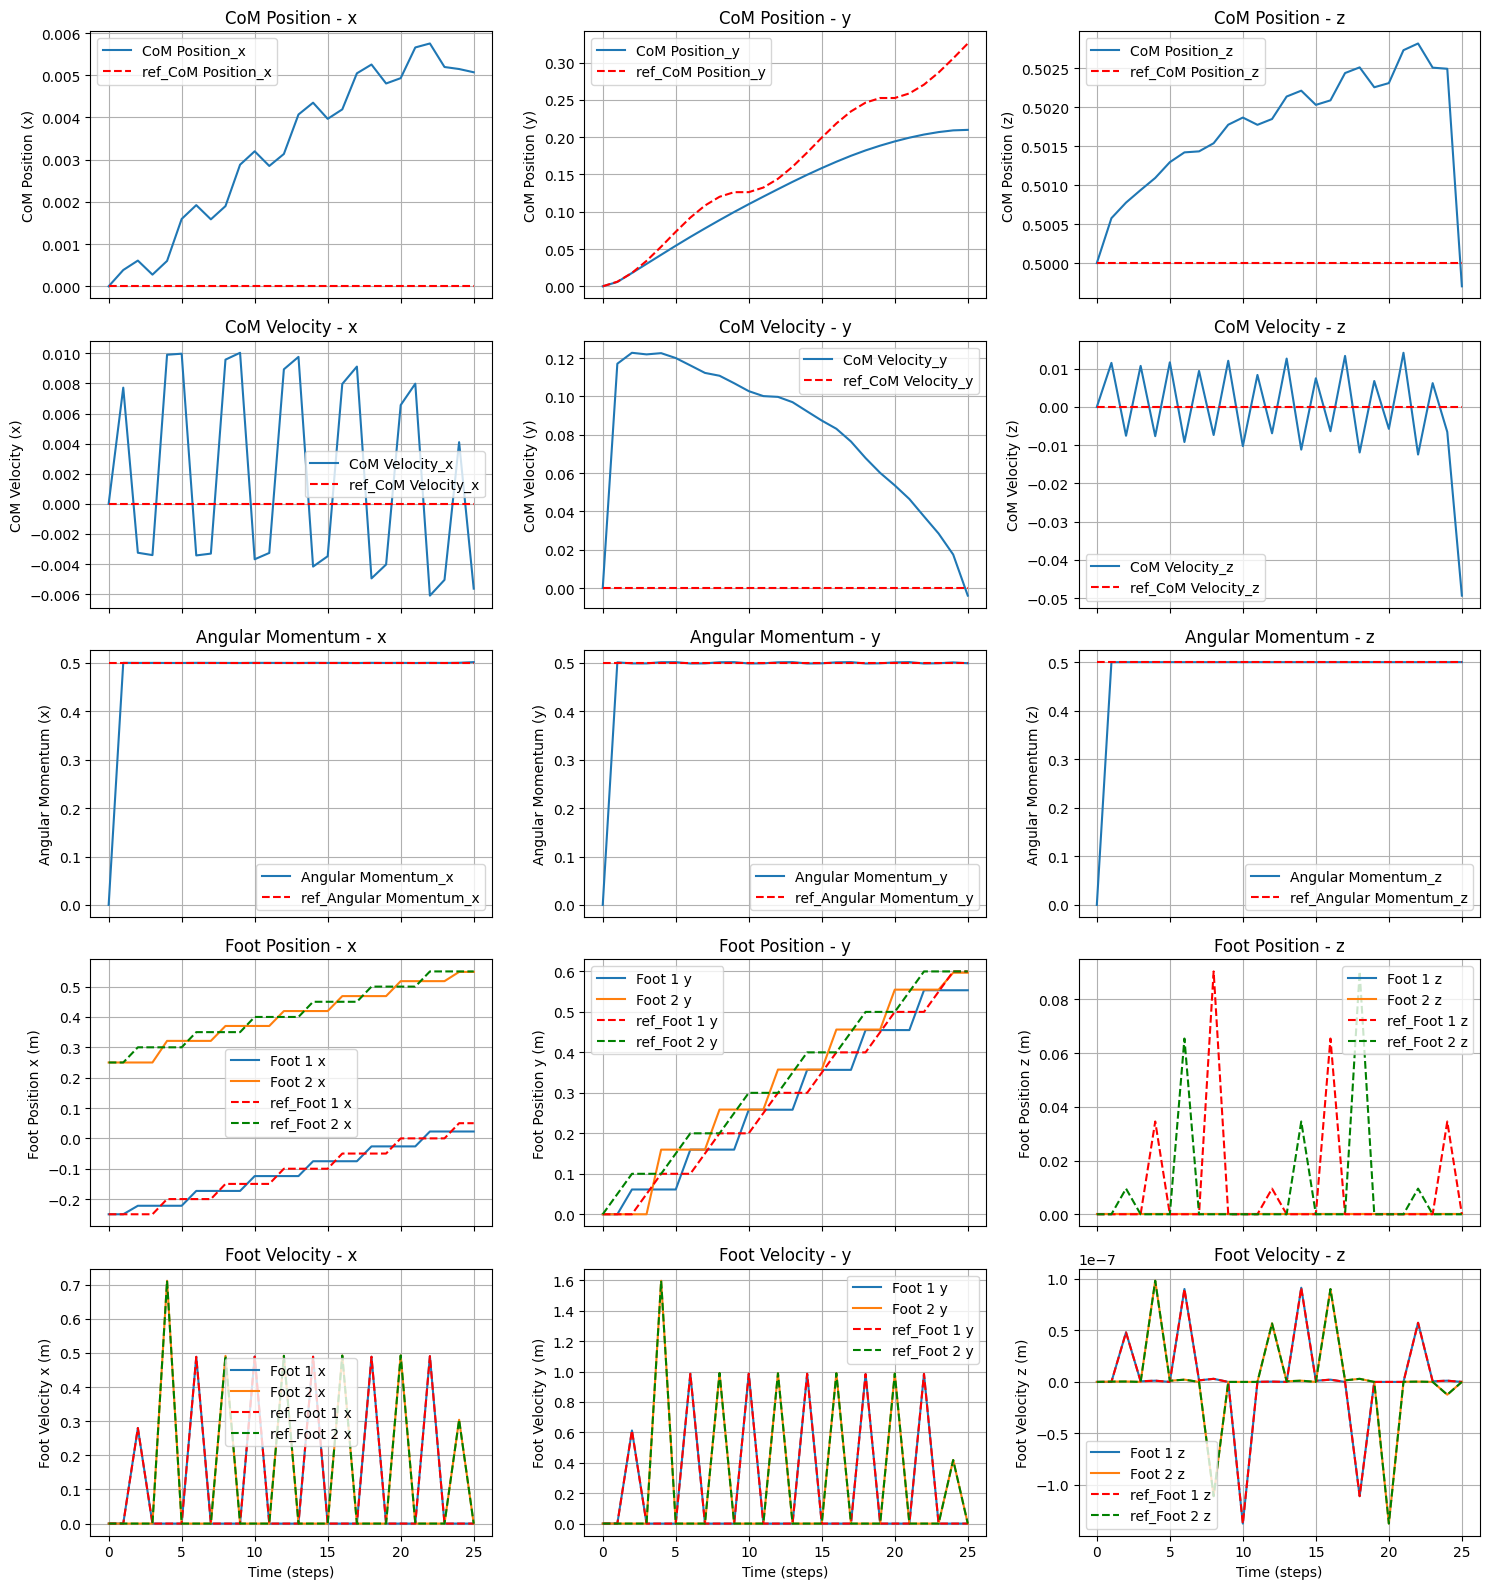

In [12]:
def evolution_plots(X, U, X_ref, U_ref, dm, ref_type):
    print(f"Evolution of X components when {ref_type}...\n")

    N_intervals = X.shape[1] # Number of intervals
    N = N_intervals-1
    time = np.arange(N_intervals)  # Create a time vector

    # Extract components for plotting
    positions, velocities, momentum, foot_positions_L, foot_velocities_L = [], [], [], [], []
    ref_position, ref_velocity, ref_momentum, ref_P_L_k, ref_foot_velocities_L = [], [], [], [], []
    
    # Loop to extract the relevant components
    for k in range(N_intervals):
        x_k = X[:, k]
        x_ref_k = X_ref[:, k]
        if N > 1 and N<U.shape[1]:
            u_k = U[:,k]
            u_k_ref = U_ref[:,k]
        elif N == 1:
            u_k = U[:]
            u_k_ref = U_ref[:]
        else:
            u_k = U[:,k-1]
            u_k_ref = U_ref[:,k-1]
        
        # Decompose state and control
        p_k, q_k, v_k, L_k, t_k, P_L_k, Q_L_k = dm.get_x_comp(x_k)
        _, V_L_k, _, _, _, _ = dm.get_u_comp(u_k)
            
        ref_pos, _, ref_vel, ref_for, _, ref_PLk, _ = dm.get_x_comp(x_ref_k)
        _, ref_V_L_k, _, _, _, _ = dm.get_u_comp(u_k)
        
        
        positions.append(p_k)
        velocities.append(v_k)
        momentum.append(L_k)
        foot_positions_L.append(P_L_k)
        foot_velocities_L.append(V_L_k)
        
        ref_position.append(ref_pos)
        ref_velocity.append(ref_vel)
        ref_momentum.append(ref_for)
        ref_P_L_k.append(ref_PLk)
        ref_foot_velocities_L.append(ref_V_L_k)
        
    r = 10
    # Convert lists to numpy arrays
    positions = np.round(np.array(positions),r)
    velocities = np.round(np.array(velocities),r)
    momentum = np.round(np.array(momentum),r)
    foot_positions_L = np.round(np.array(foot_positions_L),r)  # Shape (N_intervals, 3, 2)
    foot_velocities_L = np.round(np.array(foot_velocities_L),r)
    ref_position = np.round(np.array(ref_position),r)  
    ref_velocity = np.round(np.array(ref_velocity),r)
    ref_momentum = np.round(np.array(ref_momentum),r)
    ref_P_L_k = np.round(np.array(ref_P_L_k),r)
    ref_foot_velocities_L = np.round(np.array(ref_foot_velocities_L),r)
    
    fig, axs = plt.subplots(5, 3, figsize=(15, 16), sharex=True)

    labels = ['x', 'y', 'z']
    properties = {
        "CoM Position": (positions, ref_position, axs[0]),
        "CoM Velocity": (velocities, ref_velocity, axs[1]),
        "Angular Momentum": (momentum, ref_momentum, axs[2])
    }

    for i, (title, (values, ref_values, ax_row)) in enumerate(properties.items()):
        for j in range(3):  # Loop through x, y, z
            ax_row[j].plot(time, values[:, j], label=f"{title}_{labels[j]}")
            if ref_values is not None:
                ax_row[j].plot(time, ref_values[:, j], color='r', linestyle='--', label=f"ref_{title}_{labels[j]}")
            ax_row[j].set_ylabel(f"{title} ({labels[j]})")
            ax_row[j].set_title(f"{title} - {labels[j]}")
            ax_row[j].legend()
            ax_row[j].grid()

    # Foot Positions (P_L_k) for Left and Right Foot separately
    for j in range(3):  # Loop through x, y, z
        axs[3, j].plot(time, foot_positions_L[:, j, 0], label=f"Foot 1 {labels[j]}")
        axs[3, j].plot(time, foot_positions_L[:, j, 1], label=f"Foot 2 {labels[j]}")
        axs[3, j].plot(time, ref_P_L_k[:, j, 0], color='r', linestyle='--', label=f"ref_Foot 1 {labels[j]}")
        axs[3, j].plot(time, ref_P_L_k[:, j, 1], color='g', linestyle='--', label=f"ref_Foot 2 {labels[j]}")
        axs[3, j].set_ylabel(f"Foot Position {labels[j]} (m)")
        axs[3, j].set_title(f"Foot Position - {labels[j]}")
        axs[3, j].legend()
        axs[3, j].grid()

        axs[4, j].plot(time, foot_velocities_L[:, j, 0], label=f"Foot 1 {labels[j]}")
        axs[4, j].plot(time, foot_velocities_L[:, j, 1], label=f"Foot 2 {labels[j]}")
        axs[4, j].plot(time, ref_foot_velocities_L[:, j, 0], color='r', linestyle='--', label=f"ref_Foot 1 {labels[j]}")
        axs[4, j].plot(time, ref_foot_velocities_L[:, j, 1], color='g', linestyle='--', label=f"ref_Foot 2 {labels[j]}")
        axs[4, j].set_ylabel(f"Foot Velocity {labels[j]} (m)")
        axs[4, j].set_title(f"Foot Velocity - {labels[j]}")
        axs[4, j].legend()
        axs[4, j].grid()
        
        
    axs[-1, 0].set_xlabel("Time (steps)")
    axs[-1, 1].set_xlabel("Time (steps)")
    axs[-1, 2].set_xlabel("Time (steps)")

    plt.tight_layout()
    plt.show()

for i in range(len(solutions)):
    X_sol, U_sol = solutions[i]
    X_init_ref, U_init_ref = ref_init[i]
    evolution_plots(X=X_sol, U=U_sol, X_ref=X_init_ref, U_ref = U_init_ref, dm=dynamic_model, ref_type=references[i])

## Contact Forces

Evolution of X components when walking...



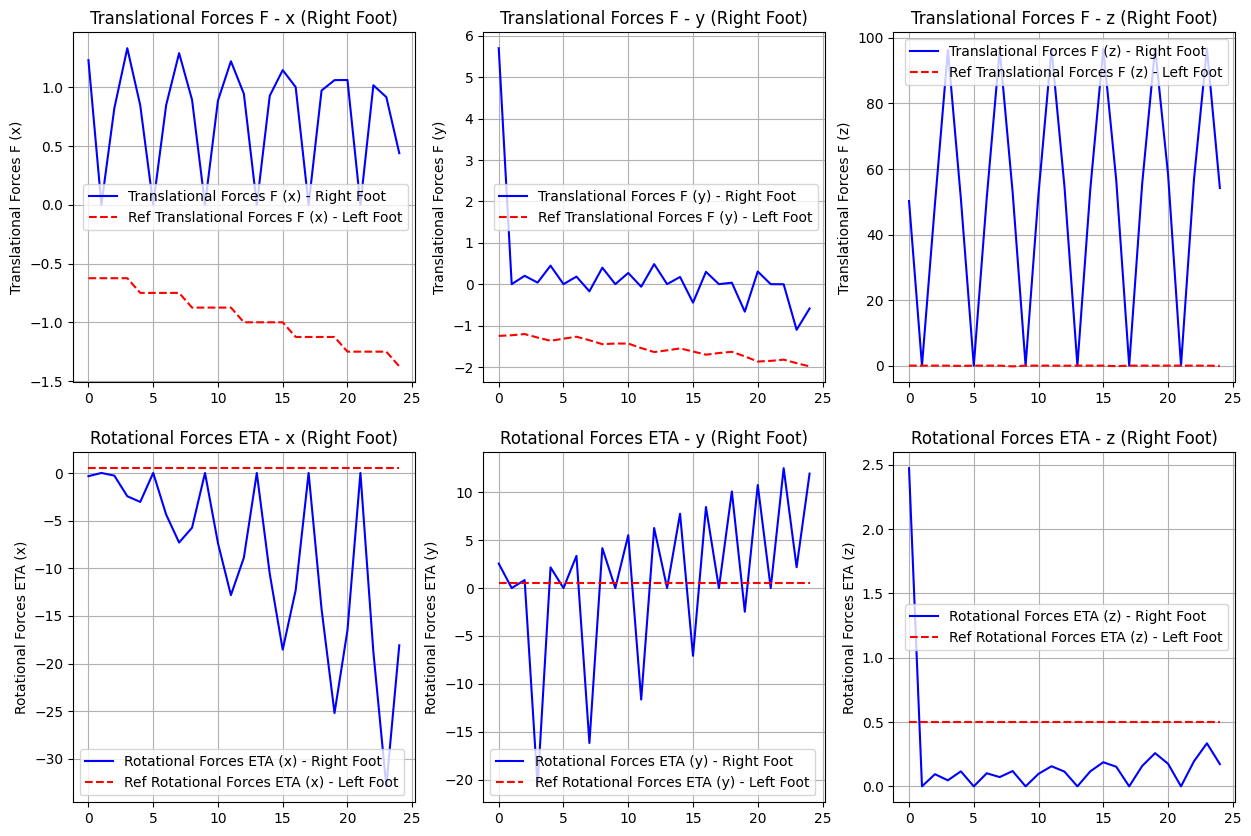

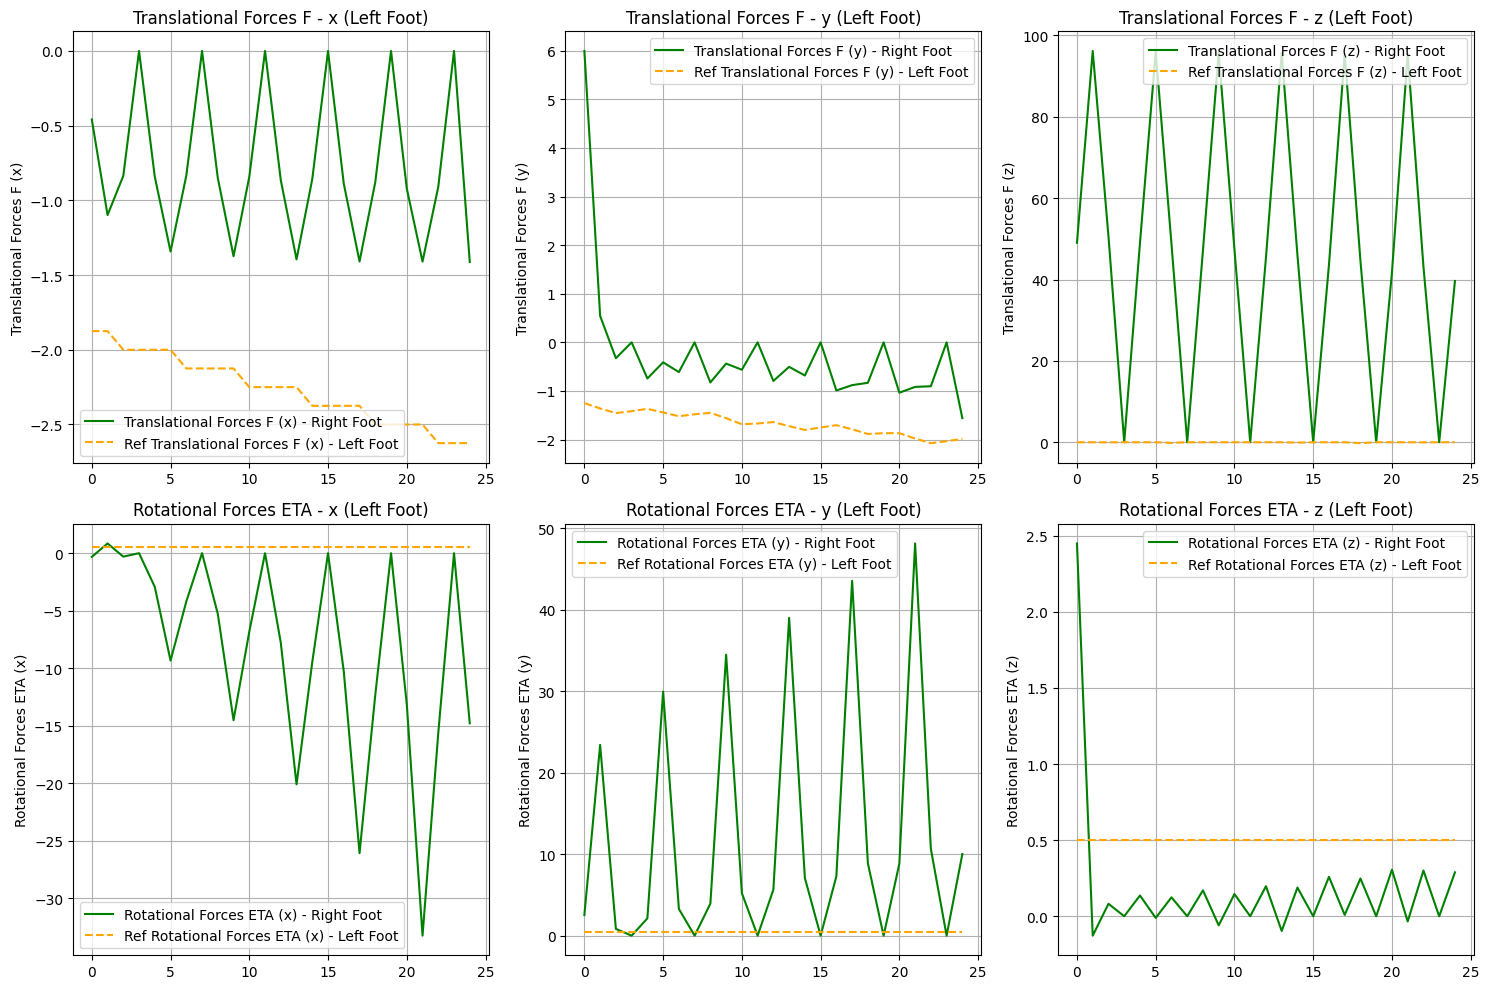

In [13]:
def evolution_contact_forces(X, X_ref, U, U_ref, dm, ref_type):
    print(f"Evolution of X components when {ref_type}...\n")

    N_intervals = X.shape[1] - 1  # Number of intervals
    time = np.arange(N_intervals)  # Create a time vector

    translational_fs, rotational_etas = [], []
    ref_translational_fs, ref_rotational_etas = [], []

    SIGMA_L_k = np.array(opti.value(dm.SIGMA_L_k)).astype("int")
    
    # Loop to extract the relevant components
    for k in range(N_intervals):
        x_k = X[:, k]
        x_ref_k = X_ref[:, k]
        if N_intervals > 1:
            u_ref_k = U_ref[:,k]
            u_k = U[:, k]
        else:
            u_ref_k = U_ref[:]
            u_k = U[:]
            
        # Decompose state and control
        p_k, q_k, v_k, L_k, t_k, P_L_k, Q_L_k = dm.get_x_comp(x_k)
        _, _, _, LAMBDA_L_k, R_L_k, ETA_HAT_L_k = dm.get_u_comp(u_k)
        ref_pos, _, ref_vel, ref_for, _, ref_PLk, _ = dm.get_x_comp(x_ref_k)
        _, _, _, ref_LAMBDALk, ref_RLk, ref_ETAHATLk = dm.get_u_comp(u_ref_k)

        F_L_k, ETA_L_k = dm.define_contact_wrench(p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k)
        F_L_k_ref, ETA_L_k_ref = dm.define_contact_wrench(ref_pos, ref_LAMBDALk, ref_PLk, ref_RLk, ref_ETAHATLk)

        translational_fs.append(F_L_k)
        rotational_etas.append(ETA_L_k)
        ref_translational_fs.append(F_L_k_ref)
        ref_rotational_etas.append(ref_ETAHATLk)
        

    # Convert lists to numpy arrays
    translational_fs = np.array(translational_fs)
    rotational_etas = np.array(rotational_etas)
    
    ref_translational_fs = np.array(ref_translational_fs)
    ref_rotational_etas = np.array(ref_rotational_etas)
    
    
    fig_left, axs_left = plt.subplots(2, 3, figsize=(15, 10))  # Left foot plots
    fig_right, axs_right = plt.subplots(2, 3, figsize=(15, 10))  # Right foot plots

    labels = ['x', 'y', 'z']

    properties = {
        "Translational Forces F": (translational_fs, ref_translational_fs),
        "Rotational Forces ETA": (rotational_etas, ref_rotational_etas),
    }

    time = np.arange(N_intervals)  # Fix the shape issue

    for i, (title, (values, ref_values)) in enumerate(properties.items()):
        for j in range(3):  # Loop through x, y, z components
    
            # Right Foot (index 0)
            axs_left[i, j].plot(time, values[:, j, 0], label=f"{title} ({labels[j]}) - Right Foot", color="b")
            """
            if N_intervals > 1:
                axs_left[i, j].set_xticks(time, labels = SIGMA_L_k[0, :], fontsize = 10)
            else:
                axs_left[i, j].set_xticks(time, labels = np.array(SIGMA_L_k), fontsize = 10)
            #axs_left[i, j].set_xticklabels(opti.value(dm.SIGMA_L_k[0, :]))
            """
            if ref_values is not None:
                axs_left[i, j].plot(time, ref_values[:, j, 0], linestyle="dashed", label=f"Ref {title} ({labels[j]}) - Left Foot", color="r")
            
                
            axs_left[i, j].set_ylabel(f"{title} ({labels[j]})")
            axs_left[i, j].set_title(f"{title} - {labels[j]} (Right Foot)")
            axs_left[i, j].legend()
            axs_left[i, j].grid()
    
            # Left Foot (index 1)
            axs_right[i, j].plot(time, values[:, j, 1], label=f"{title} ({labels[j]}) - Right Foot", color="g")
            """
            if N_intervals > 1:
                axs_right[i, j].set_xticks(time, labels = SIGMA_L_k[1, :], fontsize = 10)
            else:
                axs_left[i, j].set_xticks(time, labels = np.array(SIGMA_L_k), fontsize = 10)
            """
            if ref_values is not None:
                axs_right[i, j].plot(time, ref_values[:, j, 1], linestyle="dashed", label=f"Ref {title} ({labels[j]}) - Left Foot", color="orange")
    
            axs_right[i, j].set_ylabel(f"{title} ({labels[j]})")
            axs_right[i, j].set_title(f"{title} - {labels[j]} (Left Foot)")
            axs_right[i, j].legend()
            axs_right[i, j].grid()
    
    plt.tight_layout()
    plt.show()

for i in range(len(solutions)):
    X_sol, U_sol = solutions[i]
    X_init_ref, U_init_ref = ref_init[i]
    evolution_contact_forces(X=X_sol, X_ref=X_init_ref, U=U_sol, U_ref=U_init_ref, dm=dynamic_model, ref_type=references[i])
    


In [14]:
def checking_sum_forces(X, X_ref, U, U_ref, dm, ref_type):
    print(f"Evolution of X components when {ref_type}...\n")
    N_intervals = X.shape[1] - 1  # Number of intervals
    time = np.arange(N_intervals)  # Create a time vector
    SIGMA_L = dm.SIGMA_L_k 

    translational_fs, rotational_etas = [], []
    ref_translational_fs, ref_rotational_etas = [], []
    gravity_force = cs.DM(dm.m) * cs.DM(dm.g)
    print("gravity_force", gravity_force)
    
    # Loop to extract the relevant components
    for k in range(N_intervals):
        print(f"{k}-th interval")
        x_k = X[:, k]
        x_ref_k = X_ref[:, k]
        if N_intervals > 1:
            u_k = U[:, k]
            u_ref_k = U_ref[:,k]
            SIGMA_L_k = SIGMA_L[:, k]  
        else:
            u_k = U[:]
            u_ref_k = U_ref[:]
            SIGMA_L_k = SIGMA_L
        # Decompose state and control
        p_k, q_k, v_k, L_k, t_k, P_L_k, Q_L_k = dm.get_x_comp(x_k)
        _, _, _, LAMBDA_L_k, R_L_k, ETA_HAT_L_k = dm.get_u_comp(u_k)

        F_L_k, ETA_L_k = dm.define_contact_wrench(p_k, LAMBDA_L_k, P_L_k, R_L_k, ETA_HAT_L_k)

        print(f"left foot x : {F_L_k[0,0]} and right foot x : {F_L_k[0,1]}")
        print(f"left foot y : {F_L_k[1,0]} and right foot y : {F_L_k[1,1]}")
        print(f"left foot z : {F_L_k[2,0]} and right foot z : {F_L_k[2,1]}")
        sum_forces = cs.sum2(F_L_k)
        print(f"SIGMA_L_k : {opti.value(SIGMA_L_k)} and sum_forces : {sum_forces}")

    return 

for i in range(len(solutions)):
    X_sol, U_sol = solutions[i]
    X_init_ref, U_init_ref = ref_init[i]
    checking_sum_forces(X=X_sol, X_ref=X_init_ref, U = U_sol, U_ref = U_init_ref, dm=dynamic_model, ref_type=references[i]) 

Evolution of X components when walking...

gravity_force [0, 0, 98.1]
0-th interval
left foot x : 1.22997 and right foot x : -0.458471
left foot y : 5.69988 and right foot y : 5.99552
left foot z : 50.217 and right foot z : 49.0354
SIGMA_L_k : [0. 0.] and sum_forces : [0.771498, 11.6954, 99.2525]
1-th interval
left foot x : -1.15469e-10 and right foot x : -1.09839
left foot y : -2.28589e-10 and right foot y : 0.544459
left foot z : 2.66721e-13 and right foot z : 96.1919
SIGMA_L_k : [-1.  0.] and sum_forces : [-1.09839, 0.544459, 96.1919]
2-th interval
left foot x : 0.821235 and right foot x : -0.835791
left foot y : 0.201754 and right foot y : -0.326071
left foot z : 49.2787 and right foot z : 50.6503
SIGMA_L_k : [0. 0.] and sum_forces : [-0.0145564, -0.124317, 99.9289]
3-th interval
left foot x : 1.33177 and right foot x : -3.46816e-10
left foot y : 0.0377821 and right foot y : -2.17385e-10
left foot z : 96.2597 and right foot z : 4.3375e-13
SIGMA_L_k : [ 0. -1.] and sum_forces : [1.3

## Video Animation

Animation saved to /kaggle/working/actual_walking_animation.mp4


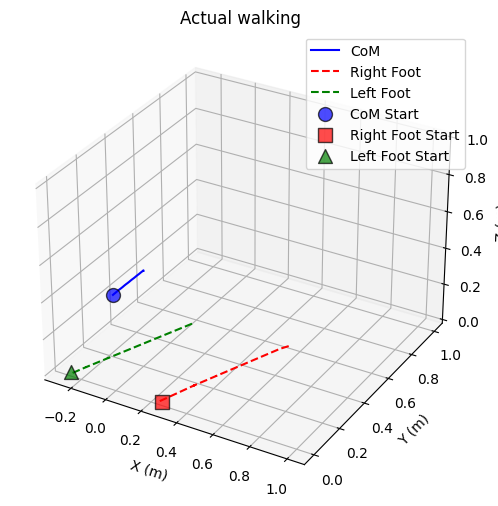

Animation saved to /kaggle/working/ref_walking_animation.mp4


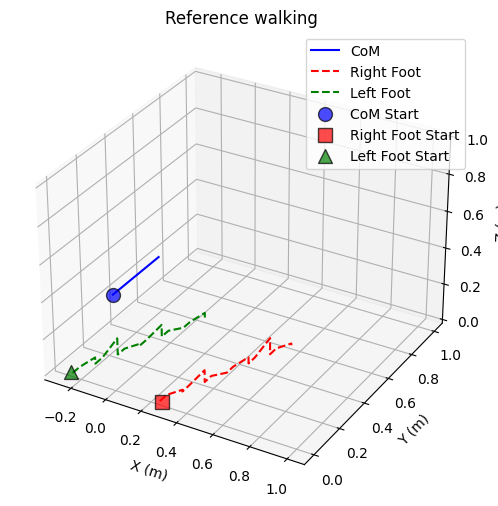

In [15]:
def animate_trajectories(X, n_e, save_path="trajectory_animation.mp4", ref_type="", label=""):
    # Clear previous figure
    plt.close('all')
    
    # Extract positions directly from X
    com_positions = X[0:3, :]  # CoM positions over time
    left_foot_positions = X[14:17, :]  # Left foot positions over time
    right_foot_positions = X[17:20, :]  # Right foot positions over time

    # Set up the figure and 3D axis
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize lines for CoM and feet
    com_line, = ax.plot([], [], [], label="CoM", color="blue", linestyle="-")
    right_foot_line, = ax.plot([], [], [], label="Right Foot", color="red", linestyle="--")
    left_foot_line, = ax.plot([], [], [], label="Left Foot", color="green", linestyle="--")

    # Add markers at the starting positions with slight offsets
    ax.scatter(com_positions[0, 0], com_positions[1, 0], com_positions[2, 0],
               color="blue", s=100, label="CoM Start", 
               edgecolor="black", alpha=0.7, marker="o")  # Circle
    
    ax.scatter(right_foot_positions[0, 0] + 0.01, right_foot_positions[1, 0], right_foot_positions[2, 0],  
               color="red", s=100, label="Right Foot Start", 
               edgecolor="black", alpha=0.7, marker="s")  # Square
    
    ax.scatter(left_foot_positions[0, 0] - 0.01, left_foot_positions[1, 0], left_foot_positions[2, 0],  
               color="green", s=100, label="Left Foot Start", 
               edgecolor="black", alpha=0.7, marker="^")  # Triangle

    # Set axis limits (adjust as needed)
    ax.set_zlim([0, np.max(X[2, :]) + 0.5])

    # Set labels, title, and legend
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"{label} {ref_type}")
    ax.legend()

    # Animation update function
    def update(frame):
        # Update lines with positions from X
        com_line.set_data(com_positions[0, :frame+1], com_positions[1, :frame+1])
        com_line.set_3d_properties(com_positions[2, :frame+1])
        
        right_foot_line.set_data(right_foot_positions[0, :frame+1], right_foot_positions[1, :frame+1])
        right_foot_line.set_3d_properties(right_foot_positions[2, :frame+1])
        
        left_foot_line.set_data(left_foot_positions[0, :frame+1], left_foot_positions[1, :frame+1])
        left_foot_line.set_3d_properties(left_foot_positions[2, :frame+1])
        
        return com_line, right_foot_line, left_foot_line

    # Create the animation
    anim = FuncAnimation(fig, update, frames=X.shape[1], interval=200, blit=False)

    # Save the animation as a video
    anim.save(save_path, writer="ffmpeg", fps=10)
    print(f"Animation saved to {save_path}")

    plt.show()
    
for i in range(len(solutions)):
    X_sol, U_sol = solutions[i] 
    X_init_ref, U_init_ref = ref_init[i]
    animate_trajectories(X_sol, n_e=2, save_path=f"/kaggle/working/actual_{references[i]}_animation.mp4", ref_type=references[i], label="Actual")
    animate_trajectories(X_init_ref, n_e=2, save_path=f"/kaggle/working/ref_{references[i]}_animation.mp4", ref_type=references[i], label="Reference")